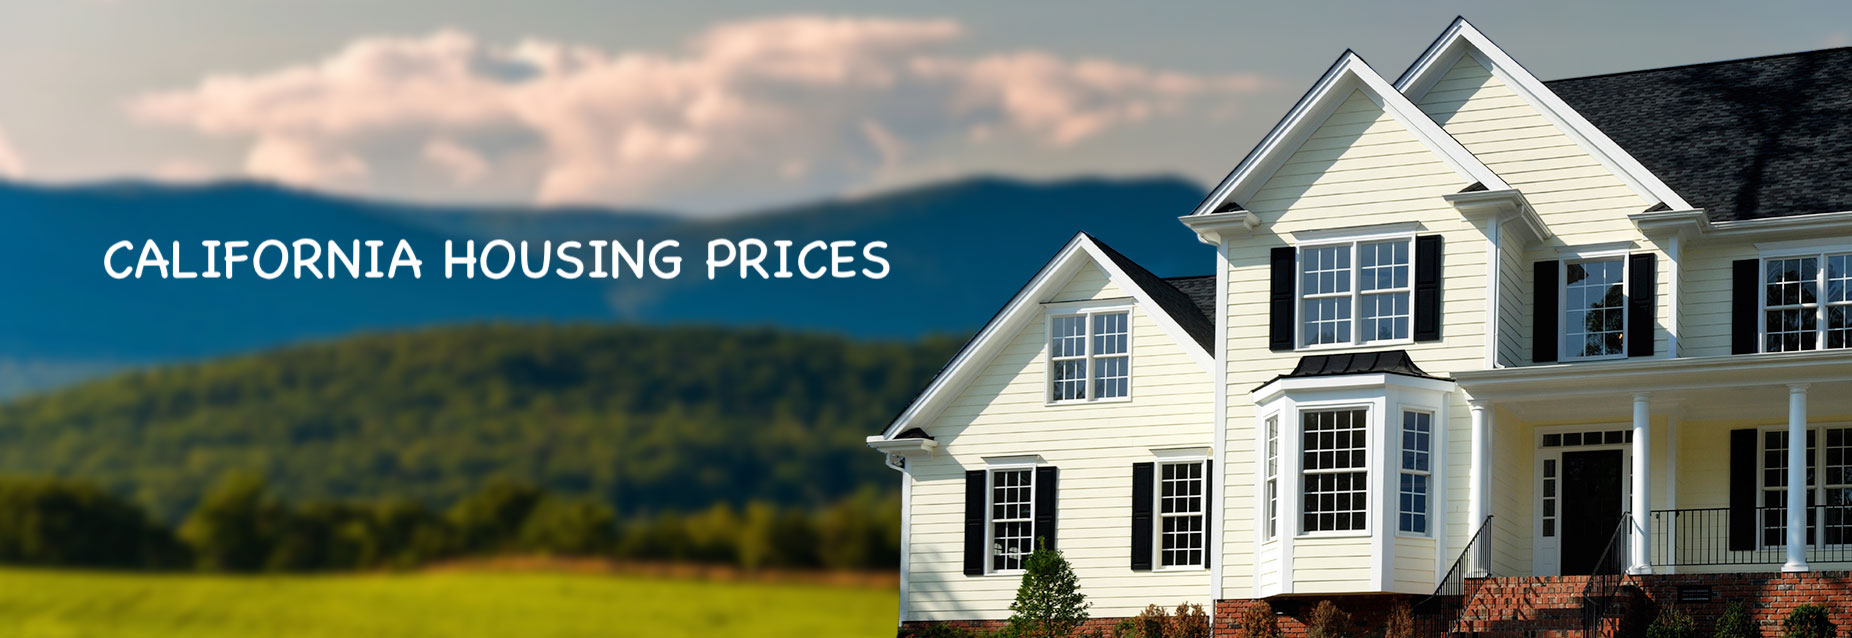

AUTHORS:   
- Abdulmalik Alrebdi 
- Saad AlOtaibi 
- Shaimaa Alghamdi 
- Sultan Alharbi

# Introduction

There is an investor who’s interested in houses and wants to have a general idea about houses price in California. 
He has a few questions such as: 

- The price of houses. 
- The suitable place to live.
- The suitable location of the houses with the fantastic view.


# Overview of the dataset

The data relates to the houses found in a given California district and some summary stats about them based on the 1990 census data. 

The observations of the dataset were described using 10 features as follows:

|Features |Description|
|-----|--------|
|Longitude|A measure of how far west a house is, a higher value is farther west |
|Latitude  |A measure of how far north a house is, a higher value is farther north  |
|housing_median_age  |Median age of a house within a block; a lower number is a newer building    |
|total_rooms  |Total number of rooms within a block     |
|Total_bedrooms  |Total number of bedrooms within a block |
|Population  |Total number of people residing within a block |
|Households  |Total number of households, a group of people residing within a home unit, for a block      |
|median_income  |Median income for households within a block of houses (measured in tens of thousands of US Dollars      |
|ocean_proximity  |Location of the house w.r.t ocean/sea  |
|median_house_value  |Median house value for households within a block (measured in US Dollars)      |



- Import 

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modeling pre-processing with scikit-learn functionality
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn import model_selection

from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
# Modeling pre-processing with non-scikit-learn packages
from category_encoders.ordinal import OrdinalEncoder
from feature_engine.encoding import RareLabelEncoder
import xgboost as xgb
# Modeling
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV


from sklearn.ensemble import RandomForestRegressor
from scipy.stats import uniform
from scipy.stats import randint
from plotnine import *
from sklearn.inspection import partial_dependence
from sklearn import linear_model




# - import The dataset

In [23]:
housing = pd.read_csv("../data/housing.csv")


# preprocessing  
## dealing with mising values

In [24]:
housing.isnull().sum() , housing.shape

(longitude               0
 latitude                0
 housing_median_age      0
 total_rooms             0
 total_bedrooms        207
 population              0
 households              0
 median_income           0
 median_house_value      0
 ocean_proximity         0
 dtype: int64,
 (20640, 10))

there are 207 mising total_bedrooms out of 20640 it is few the are many ways  to deal with that 
one way is to remove all the missing null value
or a better approach is to  fill it with the mean but we have to be carful that it will not change the main data to check 

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='total_bedrooms', ylabel='Density'>

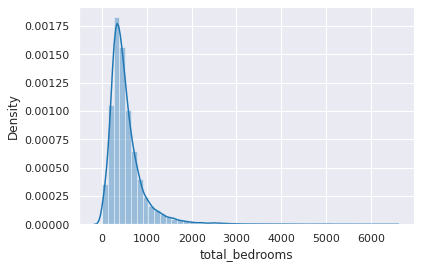

In [25]:
sns.distplot(housing['total_bedrooms']) 

this is the shape of total bed rooms before filling the NAs

In [26]:
bedrooms_mean = float(int(housing["total_bedrooms"].mean()))
housing["total_bedrooms"].fillna(bedrooms_mean, inplace = True)

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='total_bedrooms', ylabel='Density'>

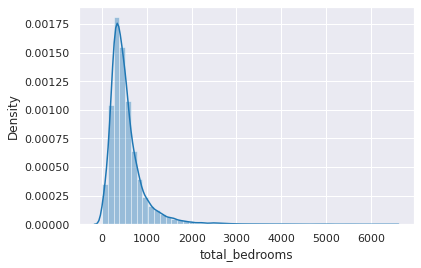

In [27]:
sns.distplot(housing['total_bedrooms']) 

this is after we can notice that there is no change in the data distribution 

# Exploratory Data Analysis (EDA)

Is the price related to the location?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


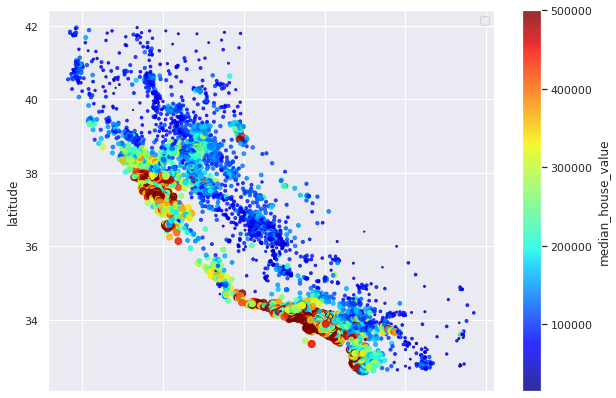

In [28]:

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.8,
s=housing["median_house_value"]/10000, figsize=(10,7),
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,)
plt.legend()


The locations of houses near the sea are considered the highest price.


What is the most common place to live?


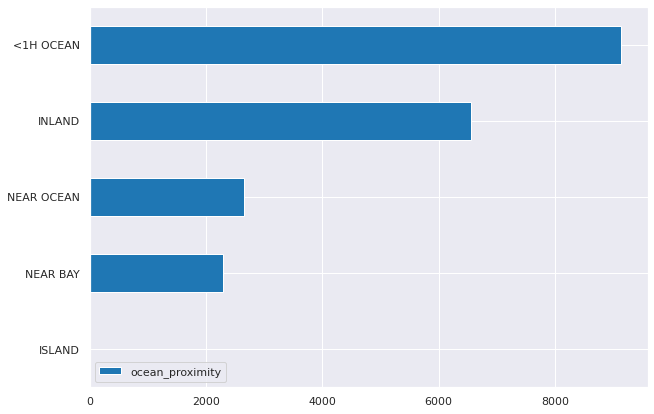

In [29]:
sns.set(palette='tab10')
housing.ocean_proximity.value_counts().sort_values(ascending=True).plot(kind='barh',figsize=(10,7))
plt.legend()

The population density is an hour away from the sea.


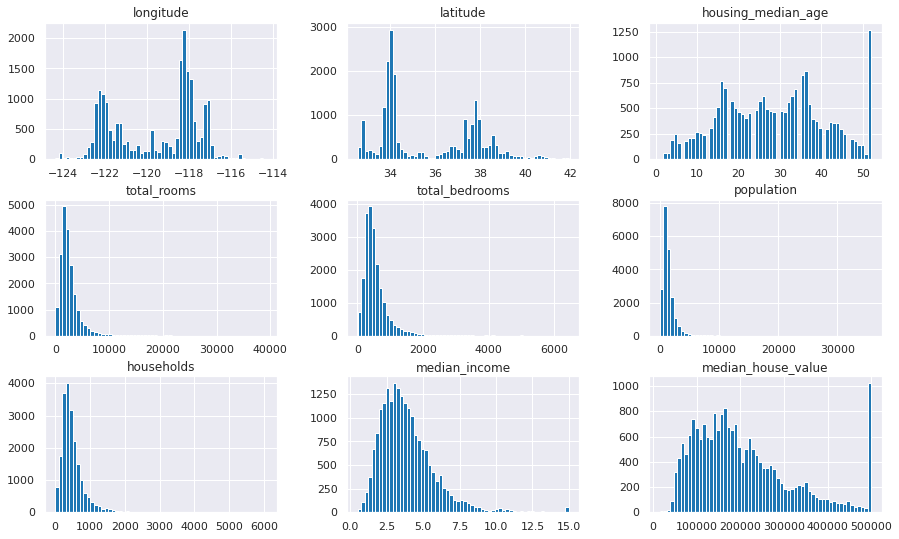

In [30]:
housing.hist(bins=60, figsize=(15,9));plt.show()

We notice that some of these features are right-side skewed so we should deal with that in the Feature engineering


# feature engineering

### separate features from labels and only use numeric features


In [31]:
train, test = train_test_split(housing, train_size=0.7, random_state=123)
X_train = train.drop("median_house_value", axis=1)
y_train = train[["median_house_value"]]

### Filter out zero or near-zero variance features.

first we have to remove all unique values and those any feature that has varince less than 10% becouse they might affect our model  

In [32]:
nzv = VarianceThreshold(threshold=0.1)

for the imputation we already delt with that in the prepossing phase 

### Normalize and Standardize the features

since there are nigative values we will use  yeo-johnson model insted of cox-Box 

In [33]:
X_norm = ColumnTransformer([("norm",  PowerTransformer(method = "yeo-johnson"), selector(dtype_include="number"))])
scaler = StandardScaler()


since we have only 10 columns we don't really need  Perform dimension reduction (PCA)

### One-hot or dummy encode categorical features.

we have only one column that is categorical whitch is ocean_proximity so we need to impelemnt one-hot  or  dummy encoding any will work fine so we chose one hot encoding

In [34]:
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

# apply to all categorical features
dummy_encoder = ColumnTransformer([("dummy", encoder, selector(dtype_include="object"))])

# Putting the process together 

In [35]:
preprocessor = ColumnTransformer(
  remainder="passthrough",
  transformers=[
  ("nzv_encode", nzv, selector(dtype_include="number")),

  ("std_encode", scaler, selector(dtype_include="number")),
 
  ("one-hot", encoder, selector(dtype_include="object")),
  ]) # notice that we already made the normaliztion above

# creating Modle 

first we thought of just implementing liear regresstion  

insert the algorithem 

In [38]:
lm_mod = linear_model.LinearRegression()

pipeline it into the prepoccing 

In [39]:
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
   ("lm", lm_mod),
])

we will use 5 split in the KFold and we will use the RMSE to measure  the ERROR rate

In [40]:
kfold = KFold(n_splits=5, random_state=123, shuffle=True)
loss = 'neg_root_mean_squared_error'

after that we have to fit and train the model 

In [42]:
cv_results = model_selection.cross_val_score(
  estimator=model_pipeline, # pipeline above 
  X=X_train, # training set 
  y=y_train, # target training set  
  cv=kfold, #number of folds cross validation 
  scoring=loss
  )

get the result

In [46]:
results = np.absolute(cv_results.mean()) 
results

68948.22458539471

we can see that the our error is 68948 we will try to reduce it as much as we can  

In [47]:
xgb_mod = xgb.XGBRegressor()

# create modeling pipeline 
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("xgb_mod", xgb_mod),
])

results = cross_val_score(model_pipeline, X_train, y_train, cv=kfold, scoring=loss)

In [49]:
np.abs(np.mean(results))


49208.19026364498

we reduced our prediction to 49208
lets see if we can do better using another model